# Find published articles missing from bioRxiv

In [1]:
from pathlib import Path
import pickle

import numpy as np
import pandas as pd
import plotnine as p9
from scipy.spatial.distance import cdist
from sklearn.linear_model import LogisticRegressionCV
import tqdm

# Load Embeddings

## bioRxiv

In [2]:
biorxiv_journal_df = (
    pd.read_csv(
        "../journal_tracker/output/mapped_published_doi_before_update.tsv", sep="\t"
    )
    .rename(index=str, columns={"doi": "preprint_doi"})
    .groupby("preprint_doi")
    .agg(
        {
            "document": "last",
            "category": "first",
            "preprint_doi": "last",
            "published_doi": "first",
            "pmcid": "first",
            "pmcoa": "first",
        }
    )
    .reset_index(drop=True)
)
biorxiv_journal_df.head()

,document,category,preprint_doi,published_doi,pmcid,pmcoa
0,000026_v1.xml,genetics,10.1101/000026,10.1371/journal.pgen.1004412,PMC4125079,True
1,000042_v2.xml,genomics,10.1101/000042,10.1038/nrg3723,PMC4151119,False
2,000067_v1.xml,genomics,10.1101/000067,10.1038/nature12904,PMC4285441,True
3,000091_v1.xml,synthetic biology,10.1101/000091,NaN,NaN,False
4,000109_v1.xml,evolutionary biology,10.1101/000109,10.1371/journal.pgen.1004410,PMC4072524,True


In [3]:
biorxiv_embed_df = pd.read_csv(
    Path("../word_vector_experiment/output/")
    / "word2vec_output/"
    / "biorxiv_all_articles_300_fixed.tsv.xz",
    sep="\t",
)
biorxiv_embed_df = biorxiv_embed_df.dropna()
biorxiv_embed_df.head()

,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,440735_v1.xml,0.063813,0.012187,-0.156229,-0.158987,0.165480,-0.346612,0.001741,-0.107139,0.684055,...,-0.140772,-0.143405,-0.081427,-0.248220,-0.771470,-0.235455,0.547801,0.859663,-0.063151,0.012667
1,775270_v1.xml,-0.201064,0.011870,-0.354809,-0.150633,0.095305,-0.507254,-0.339986,0.303313,0.944561,...,-0.115199,-0.259798,0.272955,-0.346138,-0.844158,-0.596267,0.121678,0.959160,-0.747369,-0.073314
2,242404_v1.xml,-0.204741,-0.107589,-0.062853,0.140793,0.066307,-0.463290,-0.106492,-0.040269,0.557687,...,-0.229839,-0.325765,-0.064586,-0.300529,-0.707948,-0.479390,0.381809,0.968333,-0.402499,-0.109250
3,872994_v1.xml,-0.256990,-0.055972,-0.300816,0.495731,0.290070,-0.310817,-0.481578,-0.161373,0.483896,...,0.148916,-0.217426,0.195183,-0.069086,-0.545689,-0.517949,0.265230,0.645038,-0.843499,-0.142928
4,080853_v2.xml,0.167641,0.046808,-0.709753,0.232242,-0.139213,-0.319284,-0.314807,0.310180,0.317704,...,0.540693,0.264286,0.256323,0.137184,-0.754344,-0.145583,0.032544,0.507430,-0.374320,0.473060


In [4]:
biorxiv_journal_mapped_df = biorxiv_journal_df[
    ["document", "published_doi", "pmcid", "pmcoa"]
].merge(biorxiv_embed_df, on="document")
biorxiv_journal_mapped_df.head()

,document,published_doi,pmcid,pmcoa,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,000026_v1.xml,10.1371/journal.pgen.1004412,PMC4125079,True,-0.044238,0.042773,-0.131834,-0.002672,0.135241,-0.302512,...,0.066490,-0.173164,-0.102007,-0.046054,-0.858827,-0.619672,0.374192,1.072033,-0.142945,-0.054528
1,000042_v2.xml,10.1038/nrg3723,PMC4151119,False,-0.323756,-0.230348,-0.118710,-0.179675,0.084552,-0.471139,...,-0.009326,0.055672,0.014222,-0.165799,-0.595123,-0.318799,0.480354,0.750458,-0.338961,0.010047
2,000067_v1.xml,10.1038/nature12904,PMC4285441,True,0.025268,0.164317,-0.095816,-0.145657,-0.006043,-0.322385,...,0.170596,-0.111823,0.074954,-0.173614,-0.747070,-0.613020,0.269025,0.582739,-0.374461,0.418433
3,000091_v1.xml,NaN,NaN,False,-0.132056,0.118364,-0.273165,0.298218,0.292788,-0.637130,...,0.300299,-0.441953,0.544878,-0.001271,-0.353551,-0.701067,0.296414,0.717840,-0.679277,0.032921
4,000109_v1.xml,10.1371/journal.pgen.1004410,PMC4072524,True,-0.104861,0.045978,-0.130486,0.098894,0.034303,-0.032209,...,0.171565,-0.131917,0.152926,-0.212052,-0.744034,-0.514488,0.123406,0.911272,-0.278870,0.342552


## Pubmed Central

In [5]:
pmc_articles_df = pd.read_csv(
    Path("../../pmc/exploratory_data_analysis/")
    / "output/pubmed_central_journal_paper_map.tsv.xz",
    sep="\t",
).query("article_type=='research-article'")
pmc_articles_df.head()

,journal,article_type,doi,pmcid
0,Environ_Health,research-article,10.1186/1476-069X-5-22,PMC1552054
1,Environ_Health,research-article,10.1186/1476-069X-4-12,PMC1226148
3,Environ_Health,research-article,10.1186/s12940-017-0316-3,PMC5635510
4,Environ_Health,research-article,10.1186/1476-069X-10-46,PMC3125232
5,Environ_Health,research-article,10.1186/1476-069X-11-91,PMC3533997


In [6]:
pmc_embed_df = pd.read_csv(
    Path("../../pmc/word_vector_experiment/output")
    / Path("pmc_document_vectors_300_replace.tsv.xz"),
    sep="\t",
)
pmc_embed_df.head()

,journal,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,Environ_Health,PMC1552054,-0.168362,0.044431,-0.068592,-0.025250,-0.638518,-0.302347,0.303967,-0.122796,...,0.012046,-0.156143,0.010454,-0.615891,-0.952055,-0.504918,0.113741,0.763464,-0.789372,0.009379
1,Environ_Health,PMC1226148,-0.239919,-0.060203,-0.133328,0.360897,-0.517385,-0.249687,0.056513,0.052408,...,0.321736,-0.251242,0.261475,-0.577342,-0.544784,-0.484138,0.065360,0.530282,-0.828810,-0.012625
2,Environ_Health,PMC5635510,0.048672,0.170688,-0.070395,0.236424,-0.039087,-0.381143,0.051673,-0.148415,...,0.097997,-0.170264,0.064343,-0.447883,-0.758610,-0.459414,0.433691,0.676709,-0.573157,-0.104958
3,Environ_Health,PMC3533997,-0.064178,0.173903,-0.051677,0.159768,-0.305409,-0.493326,0.267089,-0.005127,...,-0.075961,-0.404060,-0.012403,-0.567062,-1.054321,-0.372887,0.075409,0.681162,-0.849728,-0.233986
4,Environ_Health,PMC3125232,-0.186567,0.081031,-0.073595,-0.137754,0.068354,-0.406180,-0.219826,-0.108129,...,-0.090546,-0.173788,0.071811,-0.444737,-0.949252,-0.587158,0.341312,0.888989,-0.476960,-0.284114


In [7]:
pmc_journal_mapped_df = (
    pmc_articles_df[["doi", "pmcid"]]
    .merge(pmc_embed_df, left_on="pmcid", right_on="document")
    .drop("pmcid", axis=1)
)
pmc_journal_mapped_df.head()

,doi,journal,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,10.1186/1476-069X-5-22,Environ_Health,PMC1552054,-0.168362,0.044431,-0.068592,-0.025250,-0.638518,-0.302347,0.303967,...,0.012046,-0.156143,0.010454,-0.615891,-0.952055,-0.504918,0.113741,0.763464,-0.789372,0.009379
1,10.1186/1476-069X-4-12,Environ_Health,PMC1226148,-0.239919,-0.060203,-0.133328,0.360897,-0.517385,-0.249687,0.056513,...,0.321736,-0.251242,0.261475,-0.577342,-0.544784,-0.484138,0.065360,0.530282,-0.828810,-0.012625
2,10.1186/s12940-017-0316-3,Environ_Health,PMC5635510,0.048672,0.170688,-0.070395,0.236424,-0.039087,-0.381143,0.051673,...,0.097997,-0.170264,0.064343,-0.447883,-0.758610,-0.459414,0.433691,0.676709,-0.573157,-0.104958
3,10.1186/1476-069X-10-46,Environ_Health,PMC3125232,-0.186567,0.081031,-0.073595,-0.137754,0.068354,-0.406180,-0.219826,...,-0.090546,-0.173788,0.071811,-0.444737,-0.949252,-0.587158,0.341312,0.888989,-0.476960,-0.284114
4,10.1186/1476-069X-11-91,Environ_Health,PMC3533997,-0.064178,0.173903,-0.051677,0.159768,-0.305409,-0.493326,0.267089,...,-0.075961,-0.404060,-0.012403,-0.567062,-1.054321,-0.372887,0.075409,0.681162,-0.849728,-0.233986


# Calculate Distances

## biorxiv -> published versions

In [8]:
biorxiv_published = (
    biorxiv_journal_mapped_df.query("pmcid.notnull()")
    .query("pmcoa == True")
    .sort_values("pmcid", ascending=True)
    .drop_duplicates("pmcid")
    .set_index("pmcid")
)
biorxiv_published.head()

,document,published_doi,pmcoa,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
pmcid,,,,,,,,,,,,,,,,,,,,,
PMC3585962,000380_v1.xml,10.1016/j.biochi.2012.05.024,True,0.220752,0.263798,-0.577314,-0.246077,-0.035208,-0.420691,-0.527212,...,0.456167,-0.052181,0.367257,-0.403755,-0.673320,-0.708710,0.154297,0.430808,-0.677084,-0.073885
PMC3866385,000968_v1.xml,10.3389/fnhum.2013.00880,True,0.151951,0.312198,-0.193882,0.644660,0.080149,-0.282529,-0.304450,...,-0.015843,-0.172556,0.227691,0.095561,-0.819467,-0.087444,0.647902,0.644702,-0.467535,0.015701
PMC3893193,001297_v2.xml,10.1371/journal.pone.0085203,True,0.047553,-0.217550,-0.281974,0.605726,0.095775,-0.371498,-0.383721,...,0.069279,0.036545,0.550598,0.045969,-0.463814,-0.542604,0.282290,0.839154,-0.713836,-0.040004
PMC3894166,000141_v1.xml,10.1371/journal.pcbi.1003433,True,-0.205589,0.097464,-0.675844,0.092262,0.040508,-0.438993,-0.379772,...,0.480143,0.124392,0.293421,-0.014381,-0.683414,-0.626689,0.131946,0.754510,-0.273637,0.053442
PMC3906208,000315_v1.xml,10.1371/journal.pone.0087782,True,0.180890,0.230198,-0.078342,-0.147791,-0.305849,-0.282869,0.126895,...,0.333562,0.368843,-0.323412,0.054554,-0.786800,0.007266,0.623237,0.582372,-0.121047,0.118612


In [9]:
PMC_published = (
    pmc_journal_mapped_df.query(f"document in {biorxiv_published.index.tolist()}")
    .sort_values("document", ascending=True)
    .set_index("document")
)
PMC_published.head()

,doi,journal,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
document,,,,,,,,,,,,,,,,,,,,,
PMC3585962,10.1016/j.biochi.2012.05.024,Biochimie,0.220156,0.284728,-0.581323,-0.315159,0.008347,-0.420825,-0.521352,0.069432,...,0.487716,-0.037816,0.342601,-0.379607,-0.725068,-0.697136,0.237096,0.455677,-0.640347,-0.126101
PMC3866385,10.3389/fnhum.2013.00880,Front_Hum_Neurosci,0.161030,0.306958,-0.196593,0.647551,0.073000,-0.300168,-0.305422,-0.555379,...,-0.030222,-0.176580,0.246142,0.103570,-0.813839,-0.068543,0.636505,0.643648,-0.465060,0.032802
PMC3893193,10.1371/journal.pone.0085203,PLoS_One,0.058200,-0.225367,-0.240519,0.571543,0.070398,-0.363880,-0.382983,-0.101755,...,0.052293,0.058206,0.538863,0.029956,-0.498946,-0.518483,0.302252,0.854689,-0.695230,-0.024849
PMC3894166,10.1371/journal.pcbi.1003433,PLoS_Comput_Biol,-0.236055,0.063280,-0.656233,0.057372,0.012260,-0.446150,-0.379104,0.377741,...,0.486227,0.140960,0.279597,0.048827,-0.684606,-0.582842,0.125215,0.774958,-0.218518,0.014177
PMC3906208,10.1371/journal.pone.0087782,PLoS_One,0.228022,0.247925,-0.112387,-0.113850,-0.276683,-0.306004,0.112382,0.264172,...,0.342549,0.356622,-0.296086,0.022951,-0.735118,-0.027911,0.610006,0.606699,-0.155839,0.127950


In [10]:
article_distances = cdist(
    biorxiv_published.loc[PMC_published.index.tolist()].drop(
        ["document", "published_doi", "pmcoa"], axis=1
    ),
    PMC_published.drop(["doi", "journal"], axis=1),
    "euclidean",
)
article_distances.shape

(17254, 17254)

In [11]:
articles_distance_df = (
    biorxiv_published.loc[PMC_published.index.tolist()]
    .reset_index()[["document", "pmcid"]]
    .assign(
        distance=np.diag(article_distances, k=0), journal=PMC_published.journal.tolist()
    )
)
articles_distance_df.head()

,document,pmcid,distance,journal
0,000380_v1.xml,PMC3585962,0.799252,Biochimie
1,000968_v1.xml,PMC3866385,0.218622,Front_Hum_Neurosci
2,001297_v2.xml,PMC3893193,0.429524,PLoS_One
3,000141_v1.xml,PMC3894166,0.646077,PLoS_Comput_Biol
4,000315_v1.xml,PMC3906208,0.563227,PLoS_One


## biorxiv -> random paper same journal

In [12]:
PMC_off_published = (
    pmc_journal_mapped_df.drop("doi", axis=1)
    .query(f"document not in {biorxiv_published.index.tolist()}")
    .query(f"journal in {articles_distance_df.journal.unique().tolist()}")
    .groupby("journal", group_keys=False)
    .apply(lambda x: x.sample(1, random_state=100))
)
PMC_off_published.head()

,journal,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
1836891,ACS_Cent_Sci,PMC5571463,-0.340186,-0.306968,-0.702596,0.536491,0.140621,-0.360033,-0.576916,-0.076982,...,0.087754,-0.291686,0.446443,-0.035112,-0.523124,-0.059395,0.356345,0.739903,-0.627210,0.219610
1118534,ACS_Chem_Biol,PMC4301073,0.011656,-0.063791,-0.607758,-0.137784,-0.074870,-0.564718,-0.257861,0.105837,...,0.600360,-0.149413,0.341450,-0.360946,-0.422807,-0.311016,0.129340,0.432051,-0.725161,0.520676
1879014,ACS_Nano,PMC4790916,-0.060922,-0.174731,-0.632826,0.139746,-0.078651,-0.359373,-0.326040,0.094426,...,0.361489,-0.221194,0.393188,-0.345324,-0.282609,-0.171653,0.217328,0.461840,-0.806810,0.266496
1597269,ACS_Omega,PMC6868605,0.020424,-0.232566,-0.535191,0.286804,-0.134559,-0.365845,-0.240750,0.008937,...,0.278665,-0.425945,0.280616,-0.442982,-0.226565,-0.363241,0.163908,0.461276,-0.805770,0.222521
498652,ACS_Synth_Biol,PMC4161666,0.075996,-0.107891,-0.693902,-0.279629,0.255383,-0.552281,-0.283330,0.324518,...,0.310023,0.049912,0.252315,-0.166630,-0.503675,0.140086,0.352067,0.436831,-0.451523,0.830000


In [13]:
journal_mapper = {
    journal: col for col, journal in enumerate(PMC_off_published.journal.tolist())
}
list(journal_mapper.items())[0:10]

[('ACS_Cent_Sci', 0),
 ('ACS_Chem_Biol', 1),
 ('ACS_Nano', 2),
 ('ACS_Omega', 3),
 ('ACS_Synth_Biol', 4),
 ('AIDS', 5),
 ('AIDS_Res_Hum_Retroviruses', 6),
 ('AIMS_Genet', 7),
 ('AMB_Express', 8),
 ('APL_Bioeng', 9)]

In [14]:
off_article_dist = cdist(
    biorxiv_published.loc[PMC_published.index.tolist()]
    .drop(["document", "published_doi", "pmcoa"], axis=1)
    .values,
    PMC_off_published.drop(["document", "journal"], axis=1).values,
    "euclidean",
)
off_article_dist.shape

(17254, 911)

In [15]:
data = []
for idx, row in tqdm.tqdm(articles_distance_df.iterrows()):
    if row["journal"] in journal_mapper:
        data.append(
            {
                "document": row["document"],
                "pmcid": (
                    PMC_off_published.query(f"journal=='{row['journal']}'")
                    .reset_index()
                    .document.values[0]
                ),
                "journal": row["journal"],
                "distance": off_article_dist[idx, journal_mapper[row["journal"]]],
            }
        )

17254it [01:38, 175.62it/s]


In [16]:
final_df = articles_distance_df.assign(label="pre_vs_published").append(
    pd.DataFrame.from_records(data).assign(label="pre_vs_random")
)
final_df.head()

,document,pmcid,distance,journal,label
0,000380_v1.xml,PMC3585962,0.799252,Biochimie,pre_vs_published
1,000968_v1.xml,PMC3866385,0.218622,Front_Hum_Neurosci,pre_vs_published
2,001297_v2.xml,PMC3893193,0.429524,PLoS_One,pre_vs_published
3,000141_v1.xml,PMC3894166,0.646077,PLoS_Comput_Biol,pre_vs_published
4,000315_v1.xml,PMC3906208,0.563227,PLoS_One,pre_vs_published


In [17]:
final_df = biorxiv_journal_df[["document", "preprint_doi"]].merge(final_df)
final_df.to_csv(
    "output/annotated_links/article_distances_rerun.tsv", sep="\t", index=False
)
final_df.head()

,document,preprint_doi,pmcid,distance,journal,label
0,000026_v1.xml,10.1101/000026,PMC4125079,1.360377,PLoS_Genet,pre_vs_published
1,000026_v1.xml,10.1101/000026,PMC4473527,5.396874,PLoS_Genet,pre_vs_random
2,000067_v1.xml,10.1101/000067,PMC4285441,0.470905,Nature,pre_vs_published
3,000067_v1.xml,10.1101/000067,PMC6175059,6.073076,Nature,pre_vs_random
4,000109_v1.xml,10.1101/000109,PMC4072524,0.533702,PLoS_Genet,pre_vs_published


# Distribution plot

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/biorxiv_article_distance_rerun.svg
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/biorxiv_article_distance_rerun.png


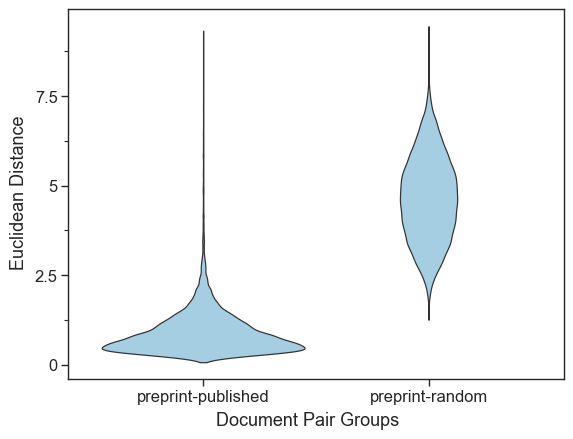

<ggplot: (8792118796878)>


In [18]:
g = (
    p9.ggplot(
        final_df.replace(
            {
                "pre_vs_published": "preprint-published",
                "pre_vs_random": "preprint-random",
            }
        )
    )
    + p9.aes(x="label", y="distance")
    + p9.geom_violin(fill="#a6cee3")
    + p9.labs(x="Document Pair Groups", y="Euclidean Distance")
    + p9.theme_seaborn(context="paper", style="ticks", font="Arial", font_scale=2)
)
g.save("output/figures/biorxiv_article_distance.svg")
g.save("output/figures/biorxiv_article_distance.png")
print(g)

# Logistic Regression bioRxiv preprints -> published PMC articles

In [19]:
model = LogisticRegressionCV(
    Cs=5,
    cv=10,
    random_state=100,
    penalty="elasticnet",
    solver="saga",
    l1_ratios=[0.1, 0.5, 0.8],
    verbose=1,
)

In [20]:
retained_ids = list(
    set(PMC_published.index.tolist()) & set(biorxiv_published.index.tolist())
)

In [21]:
training_dataset = (
    biorxiv_published.dropna()
    .drop(["document", "published_doi", "pmcoa"], axis=1)
    .loc[retained_ids]
    - PMC_published.loc[retained_ids].dropna().drop(["journal", "doi"], axis=1)
).assign(
    biorxiv_document=biorxiv_published.loc[retained_ids].document.values, true_link=1
)
training_dataset.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299,biorxiv_document,true_link
pmcid,,,,,,,,,,,,,,,,,,,,,
PMC6440972,-0.062344,-0.040440,-0.012551,-0.011989,0.027631,0.046804,0.015424,-0.013870,0.007868,-0.016947,...,-0.023963,-0.011633,-0.019742,0.003171,0.003928,-0.027142,0.013841,0.013521,491894_v1.xml,1
PMC6853891,-0.008050,-0.000412,-0.034198,0.013235,-0.006817,0.014641,0.022394,-0.016107,0.009814,0.018810,...,-0.010383,0.031649,-0.053087,0.006611,-0.013132,0.008452,-0.022189,-0.007484,776732_v1.xml,1
PMC5674756,0.036540,-0.002605,0.032920,-0.165682,0.064750,-0.023302,0.030987,0.020110,-0.098536,0.032745,...,-0.016515,0.121043,-0.087976,0.028152,0.101607,-0.026265,0.167324,-0.021506,087775_v1.xml,1
PMC6959356,-0.023638,0.116159,-0.088119,-0.172646,0.109414,0.006080,-0.068100,0.043459,-0.004420,-0.076926,...,-0.003855,0.142526,-0.139690,0.042965,0.178414,0.032840,0.186940,0.024983,403527_v2.xml,1
PMC5663985,-0.011048,0.001895,-0.073110,-0.024940,0.018035,0.015996,0.014427,-0.002551,0.000753,-0.037400,...,0.019581,-0.017504,-0.004655,-0.026730,-0.000567,-0.029126,-0.023003,0.046198,196931_v1.xml,1


In [22]:
journals = (
    PMC_published.loc[retained_ids]
    .query(f"journal in {PMC_off_published.journal.tolist()}")
    .journal.values.tolist()
)

In [23]:
off_documents = (
    PMC_published.loc[retained_ids]
    .query(f"journal in {PMC_off_published.journal.tolist()}")
    .index.tolist()
)

In [24]:
training_dataset = (
    training_dataset.append(
        pd.DataFrame(
            biorxiv_published.loc[off_documents]
            .drop(["document", "published_doi", "pmcoa"], axis=1)
            .values
            - PMC_off_published.iloc[list(map(lambda x: journal_mapper[x], journals))]
            .set_index("journal")
            .drop("document", axis=1)
            .values,
            columns=[f"feat_{idx}" for idx in range(300)],
        ).assign(true_link=-1)
    )
    .reset_index(drop=True)
    .drop("biorxiv_document", axis=1)
    .dropna()
)
training_dataset.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299,true_link
0,-0.062344,-0.040440,-0.012551,-0.011989,0.027631,0.046804,0.015424,-0.013870,0.007868,-0.016947,...,-0.000829,-0.023963,-0.011633,-0.019742,0.003171,0.003928,-0.027142,0.013841,0.013521,1
1,-0.008050,-0.000412,-0.034198,0.013235,-0.006817,0.014641,0.022394,-0.016107,0.009814,0.018810,...,0.010266,-0.010383,0.031649,-0.053087,0.006611,-0.013132,0.008452,-0.022189,-0.007484,1
2,0.036540,-0.002605,0.032920,-0.165682,0.064750,-0.023302,0.030987,0.020110,-0.098536,0.032745,...,0.096541,-0.016515,0.121043,-0.087976,0.028152,0.101607,-0.026265,0.167324,-0.021506,1
3,-0.023638,0.116159,-0.088119,-0.172646,0.109414,0.006080,-0.068100,0.043459,-0.004420,-0.076926,...,0.248154,-0.003855,0.142526,-0.139690,0.042965,0.178414,0.032840,0.186940,0.024983,1
4,-0.011048,0.001895,-0.073110,-0.024940,0.018035,0.015996,0.014427,-0.002551,0.000753,-0.037400,...,0.007140,0.019581,-0.017504,-0.004655,-0.026730,-0.000567,-0.029126,-0.023003,0.046198,1


In [25]:
fit_model = model.fit(
    training_dataset.sample(frac=1, random_state=100).drop("true_link", axis=1),
    training_dataset.sample(frac=1, random_state=100).true_link,
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 12 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 13 seconds
rescaling...
rescaling...
rescaling...


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 3 epochs took 0 seconds
convergence after 14 epochs took 2 seconds
max_iter reached after 12 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 12 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 13 seconds
rescaling...


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


rescaling...
rescaling...
convergence after 3 epochs took 1 seconds
convergence after 15 epochs took 1 seconds
max_iter reached after 12 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 13 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 13 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 13 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 12 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


rescaling...
rescaling...
rescaling...
rescaling...
convergence after 3 epochs took 0 seconds
convergence after 14 epochs took 2 seconds
max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 12 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 13 seconds
rescaling...
rescaling...


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


rescaling...
convergence after 3 epochs took 0 seconds
convergence after 15 epochs took 2 seconds
max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 12 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 12 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 12 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 13 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


rescaling...
rescaling...
rescaling...
rescaling...
convergence after 3 epochs took 0 seconds
convergence after 14 epochs took 2 seconds
max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 12 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 13 seconds
rescaling...
rescaling...


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


rescaling...
convergence after 3 epochs took 0 seconds
convergence after 15 epochs took 2 seconds
max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 12 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 12 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 13 epochs took 2 seconds
convergence after 15 epochs took 1

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 12 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 12 seconds
rescaling...
rescaling...
rescaling...
convergence after 1 epochs took 1 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


convergence after 15 epochs took 1 seconds
max_iter reached after 12 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 12 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 12 seconds
rescaling...
convergence after 1 epochs took 1 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


convergence after 15 epochs took 1 seconds
max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 12 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 13 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 13 epochs took 1 seconds
convergence after 15 epochs took 2

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 13 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 13 seconds
rescaling...
rescaling...
rescaling...
convergence after 1 epochs took 0 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


convergence after 15 epochs took 2 seconds
max_iter reached after 12 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 13 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 13 seconds
rescaling...
convergence after 1 epochs took 0 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


convergence after 15 epochs took 2 seconds
max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 13 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 12 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 13 epochs took 2 seconds
convergence after 15 

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 12 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 13 seconds
rescaling...
rescaling...
rescaling...
convergence after 1 epochs took 0 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


convergence after 14 epochs took 2 seconds
max_iter reached after 12 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 12 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 13 seconds
rescaling...
convergence after 1 epochs took 0 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


convergence after 15 epochs took 2 seconds
max_iter reached after 12 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 12 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 13 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 13 epochs took 1 seconds
convergence after 15 

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 13 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 13 seconds
rescaling...
rescaling...
rescaling...
convergence after 1 epochs took 0 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


convergence after 14 epochs took 2 seconds
max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 12 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 13 seconds
rescaling...
convergence after 1 epochs took 0 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


convergence after 15 epochs took 2 seconds
max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 13 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 13 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 13 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 12 seconds
rescaling...
rescaling...
rescaling...
convergence after 1 epochs took 1 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


convergence after 15 epochs took 1 seconds
max_iter reached after 12 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 13 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 12 seconds
rescaling...
convergence after 1 epochs took 0 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


convergence after 15 epochs took 2 seconds
max_iter reached after 12 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 12 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 12 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 13 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 13 seconds
rescaling...
rescaling...
rescaling...
convergence after 1 epochs took 0 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


convergence after 14 epochs took 2 seconds
max_iter reached after 12 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 13 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 13 seconds
rescaling...
convergence after 1 epochs took 0 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


convergence after 14 epochs took 2 seconds
max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 13 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 13 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 16 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 15 seconds
rescaling...
rescaling...
rescaling...
convergence after 1 epochs took 0 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


convergence after 15 epochs took 2 seconds
max_iter reached after 14 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 15 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 15 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


rescaling...
convergence after 1 epochs took 0 seconds
convergence after 15 epochs took 2 seconds
max_iter reached after 14 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 14 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


max_iter reached after 15 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 20.1min finished


In [26]:
fit_model.scores_

{1: array([[[0.77919444, 0.50014489, 0.50014489],
         [0.88351203, 0.86554622, 0.85627354],
         [0.92031295, 0.92089249, 0.92234135],
         [0.92263112, 0.92234135, 0.92234135],
         [0.92234135, 0.92234135, 0.92263112]],
 
        [[0.77832512, 0.50014489, 0.50014489],
         [0.87684729, 0.86641553, 0.85830194],
         [0.92205158, 0.92263112, 0.92263112],
         [0.92263112, 0.92234135, 0.92234135],
         [0.92321066, 0.92321066, 0.92321066]],
 
        [[0.78585917, 0.50014489, 0.50014489],
         [0.88061431, 0.8707621 , 0.86380759],
         [0.9168357 , 0.91625616, 0.91654593],
         [0.9188641 , 0.9188641 , 0.9188641 ],
         [0.9188641 , 0.9188641 , 0.9188641 ]],
 
        [[0.7715942 , 0.50028986, 0.50028986],
         [0.88637681, 0.87391304, 0.86550725],
         [0.92492754, 0.92463768, 0.92550725],
         [0.92405797, 0.92434783, 0.92405797],
         [0.92463768, 0.92463768, 0.92463768]],
 
        [[0.77623188, 0.5       , 0.5       ]

In [27]:
pickle.dump(fit_model, open("output/optimized_model.pkl", "wb"))

# Find bioRxiv unpublished ->  published PMC articles

In [28]:
biorxiv_unpublished = biorxiv_journal_mapped_df.query("published_doi.isnull()").drop(
    ["published_doi", "pmcid", "pmcoa"], axis=1
)
print(biorxiv_unpublished.shape)
biorxiv_unpublished.head()

(39724, 301)


,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
3,000091_v1.xml,-0.132056,0.118364,-0.273165,0.298218,0.292788,-0.637130,-0.468698,0.022352,0.752860,...,0.300299,-0.441953,0.544878,-0.001271,-0.353551,-0.701067,0.296414,0.717840,-0.679277,0.032921
9,000216_v1.xml,-0.254542,-0.104913,0.152029,0.120537,-0.464280,-0.747288,0.029983,0.422532,0.521797,...,-0.268051,-0.323413,0.011982,-0.273409,-0.454082,-0.092025,0.400583,0.575322,-0.299792,0.379381
11,000240_v1.xml,-0.016990,0.278347,-0.137840,-0.044657,-0.269439,-0.168711,0.108513,0.099131,0.377821,...,0.216756,0.220975,0.291761,-0.219856,-0.759438,-0.493763,0.189564,0.729620,-0.509454,0.251340
16,000349_v1.xml,-0.357497,-0.043181,-0.289313,0.093221,0.193509,-0.203038,-0.280233,-0.160483,0.570345,...,0.068700,-0.021469,0.292037,0.214672,-0.753823,-0.404482,0.389089,1.061702,-0.399143,0.060568
17,000364_v1.xml,-0.363903,-0.183077,-0.371826,0.267140,0.100877,-0.203539,-0.179026,-0.326737,0.369509,...,0.038151,-0.068548,0.384012,-0.178070,-1.055779,-0.868002,0.250909,0.905169,-0.859033,-0.294868


In [29]:
PMC_unlinked = pmc_journal_mapped_df.query(
    f"""
        document not in {
            biorxiv_published
            .reset_index()
            .pmcid
            .tolist()
        }
        """
)
print(PMC_unlinked.shape)
PMC_unlinked.head()

(1903910, 303)


,doi,journal,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,10.1186/1476-069X-5-22,Environ_Health,PMC1552054,-0.168362,0.044431,-0.068592,-0.025250,-0.638518,-0.302347,0.303967,...,0.012046,-0.156143,0.010454,-0.615891,-0.952055,-0.504918,0.113741,0.763464,-0.789372,0.009379
1,10.1186/1476-069X-4-12,Environ_Health,PMC1226148,-0.239919,-0.060203,-0.133328,0.360897,-0.517385,-0.249687,0.056513,...,0.321736,-0.251242,0.261475,-0.577342,-0.544784,-0.484138,0.065360,0.530282,-0.828810,-0.012625
2,10.1186/s12940-017-0316-3,Environ_Health,PMC5635510,0.048672,0.170688,-0.070395,0.236424,-0.039087,-0.381143,0.051673,...,0.097997,-0.170264,0.064343,-0.447883,-0.758610,-0.459414,0.433691,0.676709,-0.573157,-0.104958
3,10.1186/1476-069X-10-46,Environ_Health,PMC3125232,-0.186567,0.081031,-0.073595,-0.137754,0.068354,-0.406180,-0.219826,...,-0.090546,-0.173788,0.071811,-0.444737,-0.949252,-0.587158,0.341312,0.888989,-0.476960,-0.284114
4,10.1186/1476-069X-11-91,Environ_Health,PMC3533997,-0.064178,0.173903,-0.051677,0.159768,-0.305409,-0.493326,0.267089,...,-0.075961,-0.404060,-0.012403,-0.567062,-1.054321,-0.372887,0.075409,0.681162,-0.849728,-0.233986


In [30]:
cutoff_score = final_df.query("label=='pre_vs_random'").distance.min()
cutoff_score

1.2532590806261803

In [31]:
chunksize = 100
chunk_iterator = range(0, biorxiv_unpublished.shape[0], chunksize)

In [33]:
for idx, chunk in tqdm.tqdm(enumerate(chunk_iterator)):

    # Chunk the documents so memory doesn't break
    biorxiv_subset = biorxiv_unpublished.iloc[chunk : chunk + chunksize]

    # Calculate distances
    paper_distances = cdist(
        biorxiv_subset.drop(["document"], axis=1),
        PMC_unlinked.drop(["journal", "document", "doi"], axis=1),
        "euclidean",
    )

    # Get elements less than threshold
    sig_indicies = np.where(paper_distances < cutoff_score)
    results = zip(
        sig_indicies[0],
        sig_indicies[1],
        paper_distances[paper_distances < cutoff_score],
    )

    # Map the results into records for pandas to parse
    results = list(
        map(
            lambda x: dict(
                document=biorxiv_subset.iloc[x[0]].document,
                pmcid=PMC_unlinked.iloc[x[1]].document,
                distance=x[2],
            ),
            results,
        )
    )

    # There may be cases where there are no matches
    if len(results) > 0:
        # Generate pandas dataframe
        potential_matches_df = (
            biorxiv_journal_df[["document", "preprint_doi"]]
            .merge(pd.DataFrame.from_records(results))
            .sort_values("distance")
        )

        # Write to file
        if idx == 0:
            potential_matches_df.to_csv(
                "output/potential_biorxiv_pmc_links_rerun.tsv", sep="\t", index=False
            )

        else:
            potential_matches_df.to_csv(
                "output/potential_biorxiv_pmc_links_rerun.tsv",
                sep="\t",
                index=False,
                mode="a",
                header=False,
            )

398it [4:30:21, 40.76s/it]


# Bin Potential Matches

In [34]:
potential_matches_df = pd.read_csv(
    "output/potential_biorxiv_pmc_links_rerun.tsv", sep="\t"
)
potential_matches_df.head()

,document,preprint_doi,pmcid,distance
0,000836_v1.xml,10.1101/000836,PMC4592070,0.543471
1,003129_v1.xml,10.1101/003129,PMC4866720,0.625801
2,002261_v1.xml,10.1101/002261,PMC4071332,0.737247
3,001719_v1.xml,10.1101/001719,PMC4832266,0.885355
4,004291_v1.xml,10.1101/004291,PMC4650676,0.916877


In [35]:
potential_matches_df = (
    potential_matches_df.rename(index=str, columns={"preprint_doi": "biorxiv_doi"})
    .drop_duplicates(["document", "biorxiv_doi", "pmcid"])
    .assign(
        pmcid_url=lambda x: (
            x.pmcid.apply(lambda paper: f"https://www.ncbi.nlm.nih.gov/pmc/{paper}")
        ),
        biorxiv_doi_url=lambda x: (
            x.biorxiv_doi.apply(lambda paper: f"https://doi.org/{paper}")
        ),
    )
)
potential_matches_df.head()

,document,biorxiv_doi,pmcid,distance,pmcid_url,biorxiv_doi_url
0,000836_v1.xml,10.1101/000836,PMC4592070,0.543471,https://www.ncbi.nlm.nih.gov/pmc/PMC4592070,https://doi.org/10.1101/000836
1,003129_v1.xml,10.1101/003129,PMC4866720,0.625801,https://www.ncbi.nlm.nih.gov/pmc/PMC4866720,https://doi.org/10.1101/003129
2,002261_v1.xml,10.1101/002261,PMC4071332,0.737247,https://www.ncbi.nlm.nih.gov/pmc/PMC4071332,https://doi.org/10.1101/002261
3,001719_v1.xml,10.1101/001719,PMC4832266,0.885355,https://www.ncbi.nlm.nih.gov/pmc/PMC4832266,https://doi.org/10.1101/001719
4,004291_v1.xml,10.1101/004291,PMC4650676,0.916877,https://www.ncbi.nlm.nih.gov/pmc/PMC4650676,https://doi.org/10.1101/004291


In [36]:
distance_bins = np.squeeze(
    final_df.query("label=='pre_vs_published'")
    .describe()
    .loc[["25%", "50%", "75%"]]
    .values
)

distance_bins = np.append(
    [0.0],
    distance_bins,
)

distance_bins = np.append(
    distance_bins, (final_df.query("label=='pre_vs_random'").distance.min())
)

distance_bins

array([0.        , 0.48376778, 0.74189217, 1.15104806, 1.25325908])

In [37]:
potential_matches_df = potential_matches_df.assign(
    distance_bin=(
        pd.cut(
            potential_matches_df.distance,
            distance_bins,
            right=False,
            labels=[
                "[0, 25%ile)",
                "[25%ile, 50%ile)",
                "[50%ile, 75%ile)",
                "[75%, min(same-journal-no-known-link))",
            ],
        )
    )
)[
    [
        "document",
        "biorxiv_doi",
        "biorxiv_doi_url",
        "pmcid",
        "pmcid_url",
        "distance",
        "distance_bin",
    ]
]

potential_matches_df.to_csv(
    "output/potential_biorxiv_pmc_links_rerun.tsv", sep="\t", index=False
)

potential_matches_df.head()

,document,biorxiv_doi,biorxiv_doi_url,pmcid,pmcid_url,distance,distance_bin
0,000836_v1.xml,10.1101/000836,https://doi.org/10.1101/000836,PMC4592070,https://www.ncbi.nlm.nih.gov/pmc/PMC4592070,0.543471,"[25%ile, 50%ile)"
1,003129_v1.xml,10.1101/003129,https://doi.org/10.1101/003129,PMC4866720,https://www.ncbi.nlm.nih.gov/pmc/PMC4866720,0.625801,"[25%ile, 50%ile)"
2,002261_v1.xml,10.1101/002261,https://doi.org/10.1101/002261,PMC4071332,https://www.ncbi.nlm.nih.gov/pmc/PMC4071332,0.737247,"[25%ile, 50%ile)"
3,001719_v1.xml,10.1101/001719,https://doi.org/10.1101/001719,PMC4832266,https://www.ncbi.nlm.nih.gov/pmc/PMC4832266,0.885355,"[50%ile, 75%ile)"
4,004291_v1.xml,10.1101/004291,https://doi.org/10.1101/004291,PMC4650676,https://www.ncbi.nlm.nih.gov/pmc/PMC4650676,0.916877,"[50%ile, 75%ile)"
